# Population & Flow Dynamics Analysis
**Data Source:** JABookings and JAReleases CSV logs (Dec 2025 - Jan 2026).

This notebook covers:
1.  **Churn Rate:** Daily Intake vs. Outflow.
2.  **Length of Stay (LoS):** Duration of confinement for released individuals.
3.  **Recidivism (Short-term):** Individuals booked multiple times in this window.
4.  **Marijuana Analysis:** Analysis of 'POSS MARIJ < 2OZ' as a sole vs. accompanying offense.

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading & Cleaning
We will load all `JABookings_*.csv` and `JAReleases_*.csv` files found in the current directory.

In [2]:
# Find all booking and release files
booking_files = sorted(glob.glob("JABookings_*.csv"))
release_files = sorted(glob.glob("JAReleases_*.csv"))

print(f"Found {len(booking_files)} booking files and {len(release_files)} release files.")

# Load Bookings
bookings_dfs = []
for f in booking_files:
    try:
        df = pd.read_csv(f)
        bookings_dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if bookings_dfs:
    bookings = pd.concat(bookings_dfs, ignore_index=True)
else:
    bookings = pd.DataFrame()

# Load Releases
releases_dfs = []
for f in release_files:
    try:
        df = pd.read_csv(f)
        releases_dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if releases_dfs:
    releases = pd.concat(releases_dfs, ignore_index=True)
else:
    releases = pd.DataFrame()

# Deduplicate (in case files overlap)
# We assume a unique record is identified by SONumber, CaseNumber, and ConfineDate (for bookings)
if not bookings.empty:
    bookings = bookings.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ConfineDate', 'ChargeOffenseDescription'])
    # Convert dates
    bookings['ConfineDate'] = pd.to_datetime(bookings['ConfineDate'], errors='coerce')

if not releases.empty:
    releases = releases.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ReleaseDate'])
    # Convert dates
    releases['ReleaseDate'] = pd.to_datetime(releases['ReleaseDate'], errors='coerce')

print(f"Total Bookings Records: {len(bookings)}")
print(f"Total Releases Records: {len(releases)}")

Found 30 booking files and 30 release files.
Total Bookings Records: 6029
Total Releases Records: 5034


## 2. Churn Rate: Daily Intake vs. Outflow
Comparing the number of people entering and leaving the system each day.

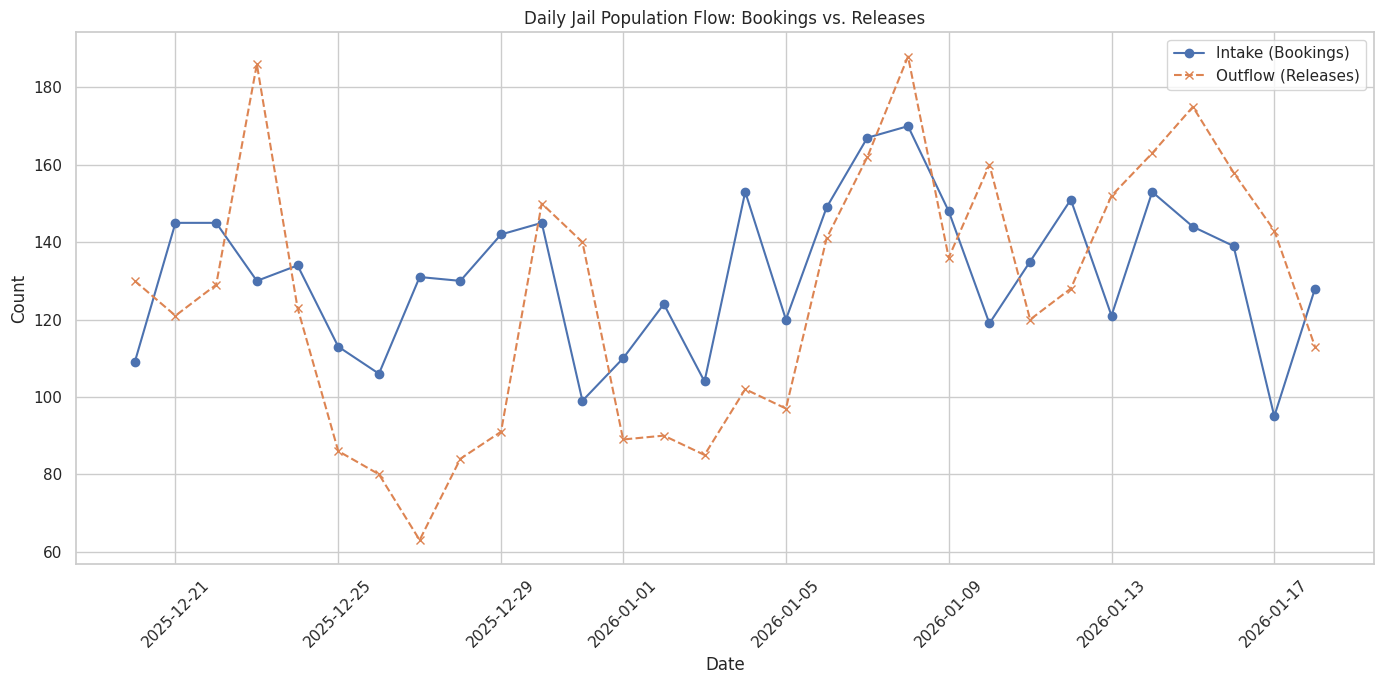

,Bookings,Releases,Net Change
2026-01-09,148,136,12
2026-01-10,119,160,-41
2026-01-11,135,120,15
2026-01-12,151,128,23
2026-01-13,121,152,-31
2026-01-14,153,163,-10
2026-01-15,144,175,-31
2026-01-16,139,158,-19
2026-01-17,95,143,-48
2026-01-18,128,113,15


In [3]:
# Count daily bookings (Unique SONumber per day)
daily_bookings = bookings.groupby('ConfineDate')['SONumber'].nunique().rename('Bookings')

# Count daily releases (Unique SONumber per day)
daily_releases = releases.groupby('ReleaseDate')['SONumber'].nunique().rename('Releases')

# Merge into one DataFrame
flow_df = pd.concat([daily_bookings, daily_releases], axis=1).fillna(0)

# Calculate Net Change
flow_df['Net Change'] = flow_df['Bookings'] - flow_df['Releases']

# Plot
plt.figure(figsize=(14, 7))
plt.plot(flow_df.index, flow_df['Bookings'], label='Intake (Bookings)', marker='o', linestyle='-')
plt.plot(flow_df.index, flow_df['Releases'], label='Outflow (Releases)', marker='x', linestyle='--')
plt.title('Daily Jail Population Flow: Bookings vs. Releases')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(flow_df.tail(10))

## 3. Length of Stay (LoS)
We calculate LoS by matching `SONumber` from Bookings to Releases.

Matched 2506 release events to booking events.
count    2506.000000
mean        2.278931
std         4.106371
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        28.000000
Name: LoS_Days, dtype: float64


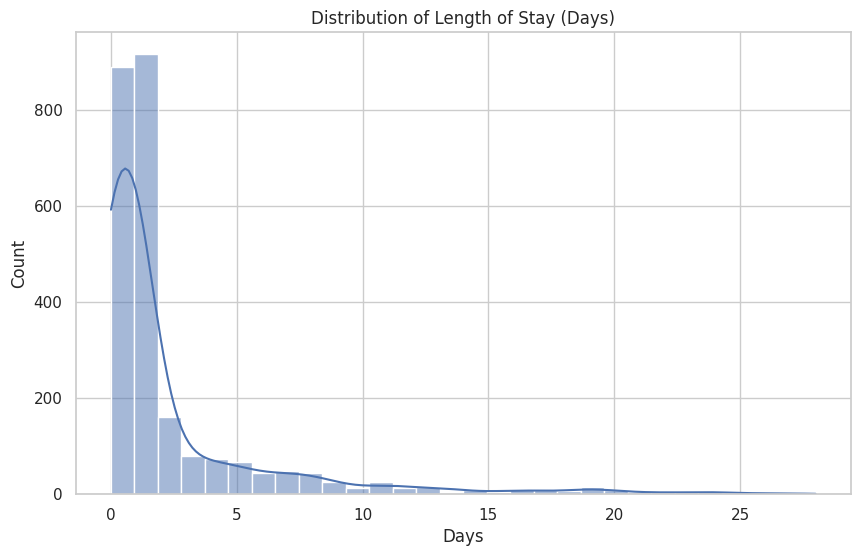

In [4]:
# Prepare for merge
b_subset = bookings[['SONumber', 'ConfineDate']].dropna().copy()
r_subset = releases[['SONumber', 'ReleaseDate']].dropna().copy()

# Sort by date
b_subset = b_subset.sort_values('ConfineDate')
r_subset = r_subset.sort_values('ReleaseDate')

# Merge on SONumber
merged = pd.merge(r_subset, b_subset, on='SONumber', how='inner')

# Filter: ConfineDate <= ReleaseDate
merged = merged[merged['ConfineDate'] <= merged['ReleaseDate']]

# Calculate LoS
merged['LoS_Days'] = (merged['ReleaseDate'] - merged['ConfineDate']).dt.days

# Handle multiple matches
matched_stays = merged.sort_values('LoS_Days').drop_duplicates(subset=['SONumber', 'ReleaseDate'], keep='first')

print(f"Matched {len(matched_stays)} release events to booking events.")

# Statistics
print(matched_stays['LoS_Days'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(matched_stays['LoS_Days'], bins=30, kde=True)
plt.title('Distribution of Length of Stay (Days)')
plt.xlabel('Days')
plt.show()

## 4. Short-term Recidivism
Identifying individuals booked multiple times.

In [5]:
recidivism_counts = bookings.groupby('SONumber')['ConfineDate'].nunique().sort_values(ascending=False)
repeat_offenders = recidivism_counts[recidivism_counts > 1]

print(f"Found {len(repeat_offenders)} individuals with multiple booking dates in this period.")

if not repeat_offenders.empty:
    print()
    print("Top repeat offenders (SONumber : Count):")
    print(repeat_offenders.head(10))
    
    # Let's look at one example
    example_so = repeat_offenders.index[0]
    print()
    print(f"Booking history for SONumber {example_so}:")
    display(bookings[bookings['SONumber'] == example_so][['ConfineDate', 'ChargeOffenseDescription', 'CaseNumber']])
else:
    print("No repeat offenders found in this specific window.")

Found 64 individuals with multiple booking dates in this period.

Top repeat offenders (SONumber : Count):
SONumber
1089222    3
1088941    2
1195475    2
1172447    2
1137662    2
1194385    2
1215017    2
997143     2
942940     2
1217367    2
Name: ConfineDate, dtype: int64


## 5. Marijuana Possession Analysis
Investigating 'POSS MARIJ < 2OZ' charges to determine if they are typically sole offenses or accompanying charges.

Total Booking Events involving 'POSS MARIJ < 2OZ': 189
Sole Offense: 0 (0.0%)
Accompanied by other charges: 189 (100.0%)


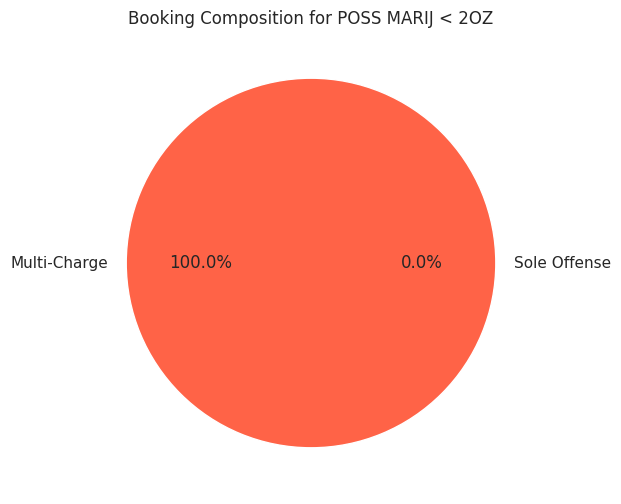


Top 10 Accompanying Charges:
ChargeOffenseDescription
UNL CARRYING WEAPON                           35
POSS CS PG 1/1-B <1G                          21
POSS CS PG 1/1-B >=1G<4G                      21
POSS CS PG 2 >= 1G < 4G                       19
EVADING ARREST DETENTION                      16
DRIVING WHILE INTOXICATED                     15
POSS CS PG 2 < 1G                             14
POSS CS PG 2 >= 4G < 400G                     12
RESIST ARREST SEARCH OR TRANSP                12
FAIL TO ID FUGITIVE INTENT GIVE FALSE INFO    10
Name: count, dtype: int64


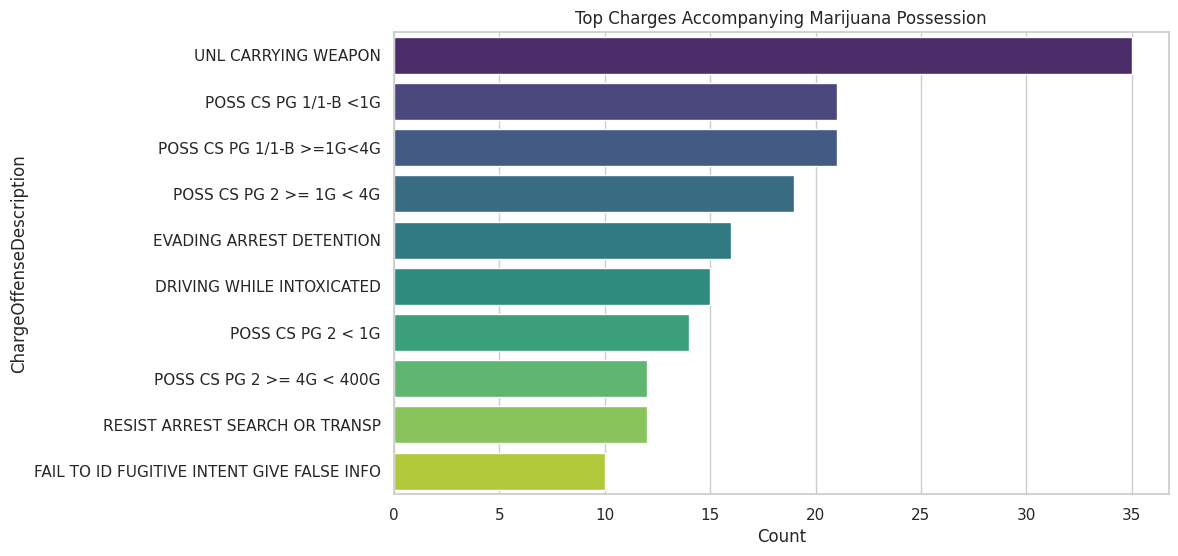

In [6]:
# Filter for Marijuana Possession
marijuana_charge = "POSS MARIJ < 2OZ"
# Find Booking Events (SONumber + Date) that include this charge
marijuana_bookings = bookings[bookings['ChargeOffenseDescription'] == marijuana_charge][['SONumber', 'ConfineDate']].drop_duplicates()

# Merge back to get ALL charges for these specific booking events
all_charges_for_mj_arrests = pd.merge(bookings, marijuana_bookings, on=['SONumber', 'ConfineDate'], how='inner')

# Count charges per booking event
charges_per_booking = all_charges_for_mj_arrests.groupby(['SONumber', 'ConfineDate']).size()

# Identify Sole Offenses (count == 1)
sole_offenses = charges_per_booking[charges_per_booking == 1]
multi_offenses = charges_per_booking[charges_per_booking > 1]

total_mj_bookings = len(charges_per_booking)

if total_mj_bookings > 0:
    print(f"Total Booking Events involving '{marijuana_charge}': {total_mj_bookings}")
    print(f'Sole Offense: {len(sole_offenses)} ({len(sole_offenses)/total_mj_bookings*100:.1f}%)')
    print(f'Accompanied by other charges: {len(multi_offenses)} ({len(multi_offenses)/total_mj_bookings*100:.1f}%)')

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie([len(sole_offenses), len(multi_offenses)], labels=['Sole Offense', 'Multi-Charge'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'])
    plt.title(f"Booking Composition for {marijuana_charge}")
    plt.show()

    # Analyze Accompanying Charges
    if not multi_offenses.empty:
        # Filter out the marijuana charge itself to see what else they were charged with
        other_charges = all_charges_for_mj_arrests[all_charges_for_mj_arrests['ChargeOffenseDescription'] != marijuana_charge]
        print("\nTop 10 Accompanying Charges:")
        print(other_charges['ChargeOffenseDescription'].value_counts().head(10))
        
        # Visualize Accompanying Charges
        plt.figure(figsize=(10, 6))
        top_accompanying = other_charges['ChargeOffenseDescription'].value_counts().head(10)
        sns.barplot(y=top_accompanying.index, x=top_accompanying.values, hue=top_accompanying.index, legend=False, palette='viridis')
        plt.title("Top Charges Accompanying Marijuana Possession")
        plt.xlabel("Count")
        plt.show()
else:
    print(f"No bookings found with charge: {marijuana_charge}")